1. Importing Tensorflow and other libraries

In [ ]:
import pandas as pd
import numpy as np
import glob
import chardet
import io
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
import os

# Traditional ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

Load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Syed Saqlain Hussain - https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset
load sqliv1 and sqliv2

Ayah Khaldi -
https://www.kaggle.com/datasets/ayahkhaldi/sql-injection-dataset
load train

Sajid576 -
https://www.kaggle.com/datasets/sajid576/sql-injection-dataset
load modified sql dataset

In [ ]:

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        raw_data = f.read(10000)
    result = chardet.detect(raw_data)
    return result['encoding']

common_columns = ["Query", "Label"]

directory_path = "/content/datasets"
csv_files = glob.glob(os.path.join(directory_path, "*.csv"))
dataframes = []

for file in csv_files:
    try:
        encoding = detect_encoding(file)
        with open(file, 'r', encoding=encoding, errors='replace') as f:
            file_content = f.read()
        df = pd.read_csv(io.StringIO(file_content), engine='python', on_bad_lines='skip')

        available_cols = [col for col in common_columns if col in df.columns]
        df = df[available_cols]
        dataframes.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

if dataframes:
    combined_data = pd.concat(dataframes, ignore_index=True)
    print(combined_data.head())
else:
    print("No dataframes loaded successfully.")

   Label Query
0    1.0   NaN
1    1.0   NaN
2    1.0   NaN
3    1.0   NaN
4    1.0   NaN


Clean the dataset to remove any missing values

In [ ]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

cleaned_data = combined_data.dropna()

Preprocess dataset

In [ ]:
print(cleaned_data.columns)

Index(['Label', 'Query'], dtype='object')


In [ ]:
cleaned_data['Query'].fillna("", inplace=True)

cleaned_data_sample = cleaned_data.sample(frac=0.4, random_state=42)

vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(cleaned_data_sample['Query']).toarray()
y = cleaned_data_sample['Label'].values

<ipython-input-13-b56a27f3a9bc>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_data['Query'].fillna("", inplace=True)
<ipython-input-13-b56a27f3a9bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Query'].fillna("", inplace=True)


Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.8, random_state=42
)

## Building the baseline CNN model

In [ ]:
X_train_cnn = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_cnn  = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

# Create a simple CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


model fitting

In [ ]:
cnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


history = cnn_model.fit(
    X_train_cnn, y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


cnn_preds_prob = cnn_model.predict(X_test_cnn)
cnn_preds = (cnn_preds_prob > 0.5).astype(int).reshape(-1)


cnn_accuracy  = accuracy_score(y_test, cnn_preds)
cnn_precision = precision_score(y_test, cnn_preds, zero_division=0)
cnn_recall    = recall_score(y_test, cnn_preds, zero_division=0)
cnn_f1        = f1_score(y_test, cnn_preds, zero_division=0)

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6504 - loss: 0.6454 - val_accuracy: 0.7306 - val_loss: 0.5401
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7250 - loss: 0.5528 - val_accuracy: 0.7267 - val_loss: 0.5336
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7306 - loss: 0.5402 - val_accuracy: 0.7413 - val_loss: 0.5268
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7219 - loss: 0.5442 - val_accuracy: 0.7418 - val_loss: 0.5225
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7260 - loss: 0.5362 - val_accuracy: 0.7393 - val_loss: 0.5220
1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


Plotting results

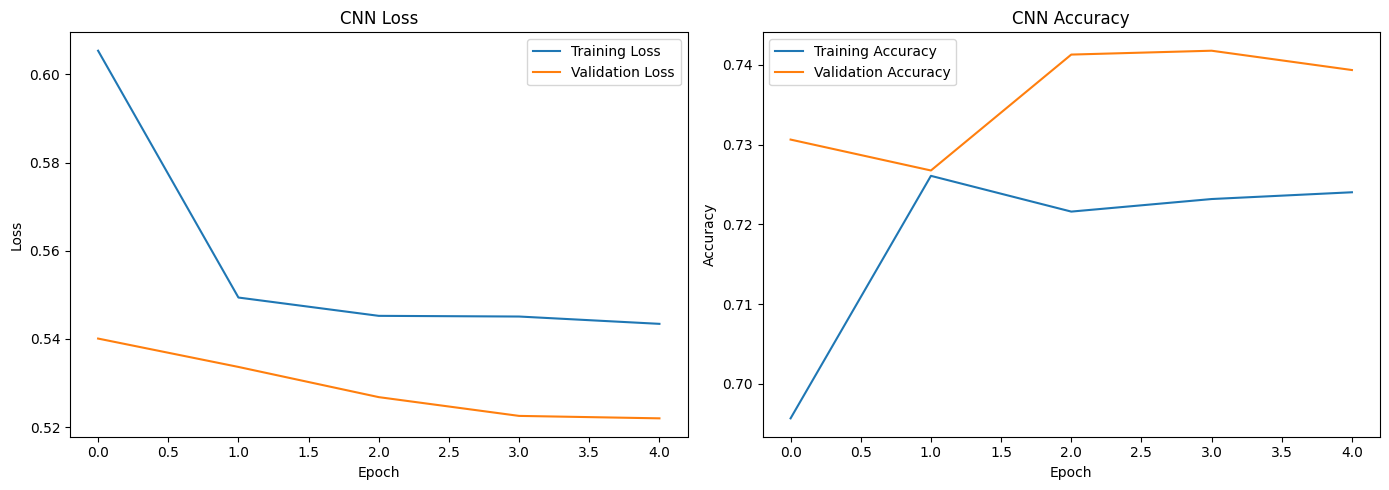

1290/1290 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
      Metric     Value
0   Accuracy  0.737680
1  Precision  0.671046
2     Recall  0.815754
3   F1 Score  0.736358


In [ ]:
plt.figure(figsize=(14, 5))

# Training/Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training/Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

cnn_preds_prob = cnn_model.predict(X_test_cnn)
cnn_preds = (cnn_preds_prob > 0.5).astype(int).reshape(-1)

# Compute evaluation metrics for the CNN baseline
cnn_accuracy = accuracy_score(y_test, cnn_preds)
cnn_precision = precision_score(y_test, cnn_preds, zero_division=0)
cnn_recall = recall_score(y_test, cnn_preds, zero_division=0)
cnn_f1 = f1_score(y_test, cnn_preds, zero_division=0)

# Create a table with the CNN results
cnn_metrics_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1]
})

print(cnn_metrics_table)

Logistic Regression, Decision Tree, Random Forest, SVM, Gradient Boosting, Naive Bayes model

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Naïve Bayes': MultinomialNB()
}

# List to store result dictionaries.
results_list = []

# Evaluate each model separately.
for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)

    # Predict on the test data.
    y_pred = model.predict(X_test_tfidf)

    # Compute evaluation metrics.
    accuracy_val  = accuracy_score(y_test, y_pred)
    precision_val = precision_score(y_test, y_pred, zero_division=0)
    recall_val    = recall_score(y_test, y_pred, zero_division=0)
    f1_val        = f1_score(y_test, y_pred, zero_division=0)

    # Append the results for the current model as a dictionary.
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy_val,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1_val
    })

# Convert the list of dictionaries to a DataFrame.
results = pd.DataFrame(results_list)

# Display the comparison table.
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.954596   0.986339  0.911519  0.947454
1        Decision Tree  0.967922   0.974472  0.953547  0.963896
2        Random Forest  0.976547   0.997282  0.950364  0.973258
3                  SVM  0.959636   0.998463  0.911519  0.953012
4    Gradient Boosting  0.965887   0.983077  0.940221  0.961171
5          Naïve Bayes  0.912172   0.912106  0.890208  0.901024


In [ ]:
cnn_result = pd.DataFrame([{
    'Model': 'CNN Baseline',
    'Accuracy': cnn_accuracy,
    'Precision': cnn_precision,
    'Recall': cnn_recall,
    'F1 Score': cnn_f1
}])

# Concatenate the new result with the existing results DataFrame
results = pd.concat([results, cnn_result], ignore_index=True)

# Sort results by F1 Score (or any metric you prefer)
results.sort_values(by='F1 Score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)

print("\nComparison Table:")
print(results)


Comparison Table:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.976547   0.997282  0.950364  0.973258
1        Decision Tree  0.967922   0.974472  0.953547  0.963896
2    Gradient Boosting  0.965887   0.983077  0.940221  0.961171
3                  SVM  0.959636   0.998463  0.911519  0.953012
4  Logistic Regression  0.954596   0.986339  0.911519  0.947454
5          Naïve Bayes  0.912172   0.912106  0.890208  0.901024
6         CNN Baseline  0.737680   0.671046  0.815754  0.736358


Bar chart comparison

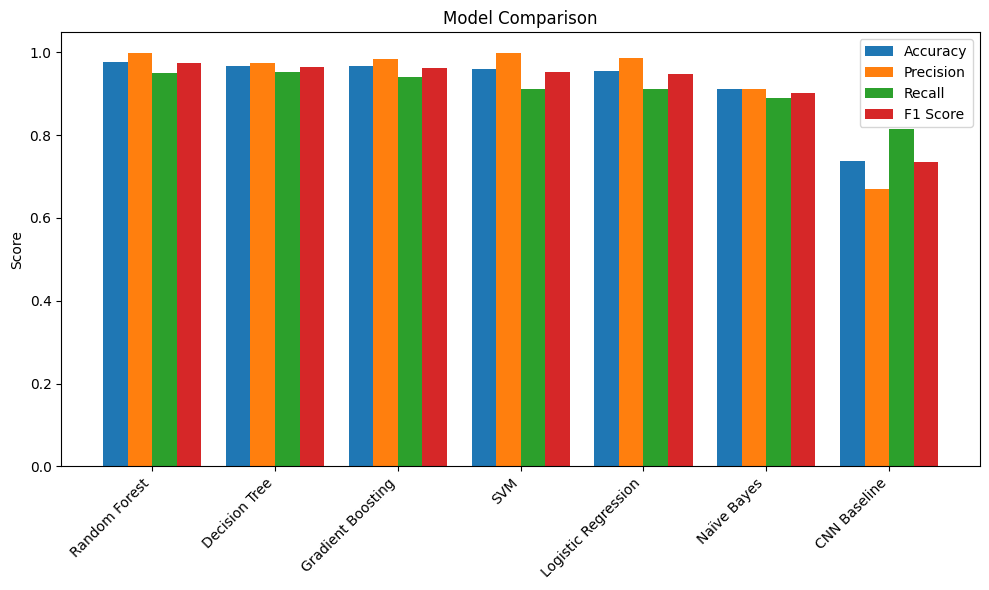

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models_list = results['Model'].tolist()

# Prepare data for plotting
x = np.arange(len(models_list))  # the label locations
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# For each metric, we create a bar next to the others
for i, metric in enumerate(metrics):
    values = results[metric].tolist()
    # Offset each bar group in the x-direction
    ax.bar(x + (i - 1.5)*width, values, width, label=metric)

# Labeling
ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

Random forest performed the best out of the algorithms however this was done with a <500 sample therefore we can manipulate teh parameters in decision tree to get the higest accuruacy

### Test dataset with adversarial inputs is introduced to test the accuracy of the model which is not similar to trained datasets

In [ ]:
new_data = pd.read_csv('/content/test_dataset/Test.csv')
new_data['Query'].fillna("", inplace=True)

new_data = new_data.dropna(subset=['Query', 'Label'])
X_new_tfidf = vectorizer.transform(new_data['Query'])
y_new = new_data['Label'].values

dt_model = models['Decision Tree']
y_new_pred = dt_model.predict(X_new_tfidf)

accuracy_new  = accuracy_score(y_new, y_new_pred)
precision_new = precision_score(y_new, y_new_pred, zero_division=0)
recall_new    = recall_score(y_new, y_new_pred, zero_division=0)
f1_new        = f1_score(y_new, y_new_pred, zero_division=0)

new_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy_new, precision_new, recall_new, f1_new]
})

print("Evaluation on New Dataset:")
print(new_results)

<ipython-input-39-f56812aaa671>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data['Query'].fillna("", inplace=True)  # Ensure missing values are handled


Evaluation on New Dataset:
      Metric     Value
0   Accuracy  0.962677
1  Precision  0.969910
2     Recall  0.950755
3   F1 Score  0.960237


## Hypertuning Parameters

## Max_depth
[10,20,30]

Results for different max_depth values:
   max_depth  Accuracy  F1 Score
0         10  0.960072  0.954359
1         20  0.971386  0.967638
2         30  0.971217  0.967497


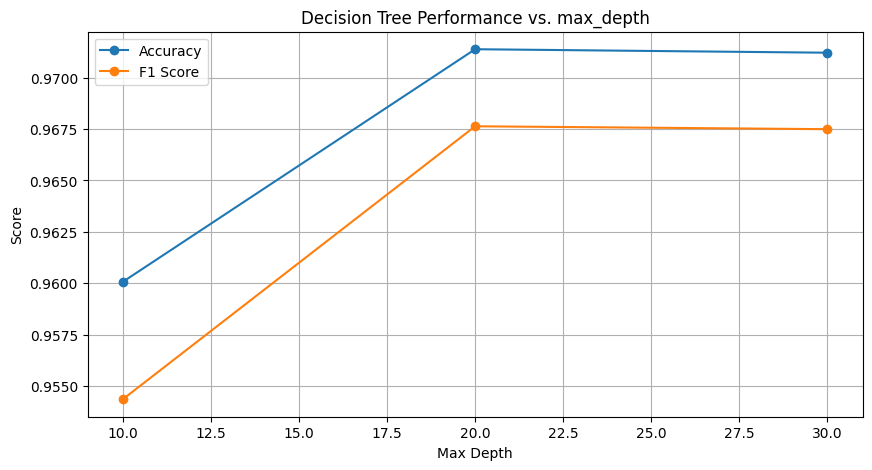

In [ ]:
max_depth_values = [10, 20, 30]

results = []

# Loop over different max_depth values
for depth in max_depth_values:
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({'max_depth': depth, 'Accuracy': accuracy_val, 'F1 Score': f1_val})

results_df = pd.DataFrame(results)
print("Results for different max_depth values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['max_depth'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['max_depth'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. max_depth')
plt.legend()
plt.grid(True)
plt.show()

20 depth produces the highest accuracy and F1 score

A moderate depth that balances capturing data complexity without making the tree too intricate.

## min_samples_split
[2.5,10]

Results for different min_samples_split values:
   min_samples_split  Accuracy  F1 Score
0                  2  0.968867  0.964995
1                  5  0.968697  0.964798
2                 10  0.969521  0.965681


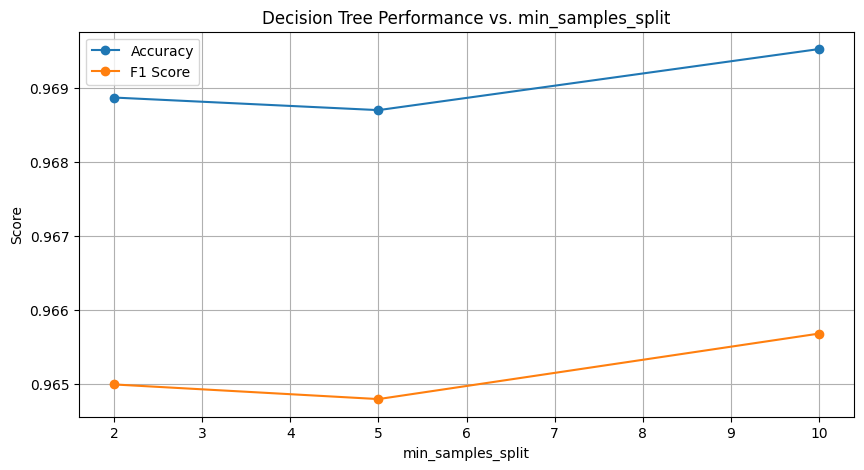

In [ ]:
min_samples_split_values = [2, 5, 10]

results = []

# Loop over different min_samples_split values.
for value in min_samples_split_values:
    dt_model = DecisionTreeClassifier(min_samples_split=value, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'min_samples_split': value,
        'Accuracy': accuracy_val,
        'F1 Score': f1_val
    })

# Convert results to a DataFrame for easier viewing and plotting.
results_df = pd.DataFrame(results)
print("Results for different min_samples_split values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['min_samples_split'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['min_samples_split'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('min_samples_split')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. min_samples_split')
plt.legend(loc='best')
plt.grid(True)
plt.show()

10 samples split produced the highest accuracy score

A more conservative setting that forces splits only when there are at least 10 samples, resulting in a simpler tree that may generalize better.

## min_samples_leaf

[1.2,4]

Results for different min_samples_leaf values:
   min_samples_leaf  Accuracy  F1 Score
0                 1  0.967752  0.963805
1                 2  0.967873  0.963663
2                 4  0.967510  0.963215


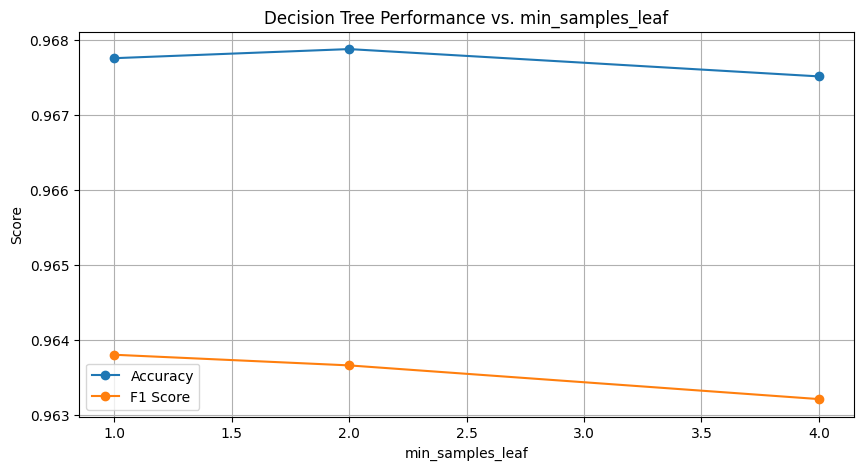

In [ ]:
min_samples_leaf_values = [1, 2, 4]

results = []

# Loop over different min_samples_leaf values.
for value in min_samples_leaf_values:
    dt_model = DecisionTreeClassifier(min_samples_leaf=value, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'min_samples_leaf': value,
        'Accuracy': accuracy_val,
        'F1 Score': f1_val
    })

# Convert results to a DataFrame for easier viewing and plotting.
results_df = pd.DataFrame(results)
print("Results for different min_samples_leaf values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['min_samples_leaf'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['min_samples_leaf'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('min_samples_leaf')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. min_samples_leaf')
plt.legend(loc='best')
plt.grid(True)
plt.show()

2 sample leaf achieves highest accuracy

A moderate number of leaf nodes that allows for some complexity but still limits the overall model size.

## max_leaf_nodes

[10,20,50]

Results for different max_leaf_nodes values:
   max_leaf_nodes  Accuracy  F1 Score
0              10  0.895455  0.882261
1              20  0.940859  0.933897
2              50  0.970635  0.966747


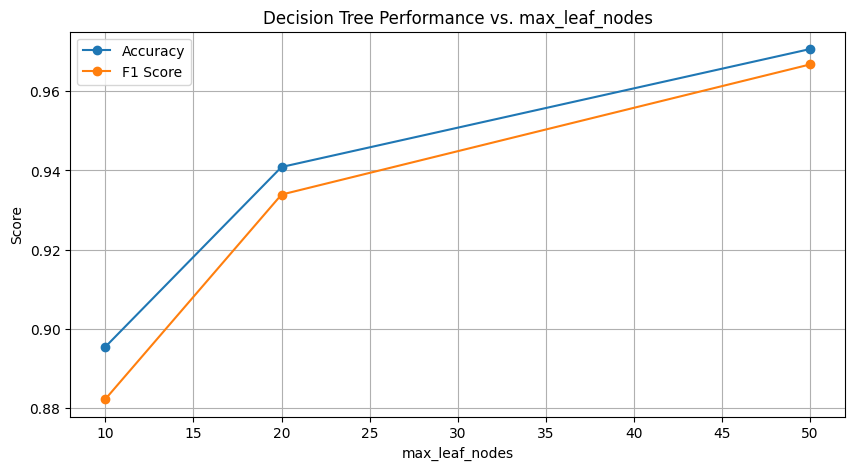

In [ ]:
max_leaf_nodes_values = [10, 20, 50]

results = []

# Loop over different max_leaf_nodes values.
for value in max_leaf_nodes_values:
    dt_model = DecisionTreeClassifier(max_leaf_nodes=value, random_state=42)
    dt_model.fit(X_train_tfidf, y_train)
    y_pred = dt_model.predict(X_test_tfidf)

    accuracy_val = accuracy_score(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred, zero_division=0)

    results.append({
        'max_leaf_nodes': value,
        'Accuracy': accuracy_val,
        'F1 Score': f1_val
    })

# Convert results to a DataFrame for easier viewing and plotting.
results_df = pd.DataFrame(results)
print("Results for different max_leaf_nodes values:")
print(results_df)

plt.figure(figsize=(10, 5))
plt.plot(results_df['max_leaf_nodes'], results_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(results_df['max_leaf_nodes'], results_df['F1 Score'], marker='o', label='F1 Score')
plt.xlabel('max_leaf_nodes')
plt.ylabel('Score')
plt.title('Decision Tree Performance vs. max_leaf_nodes')
plt.legend(loc='best')
plt.grid(True)
plt.show()

50 max leaf nodes acheived the highest accuracy

A value that allows the tree to capture more detailed patterns, at the risk of increased overfitting if not controlled by other parameters.

## Optimal decision tree model

In [ ]:
dt_model = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=2,
    max_leaf_nodes=50,
    random_state=42
)

# Fit the model on training data
dt_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_val = accuracy_score(y_test, y_pred)
f1_val = f1_score(y_test, y_pred, zero_division=0)

print("Decision Tree Performance:")
print("Accuracy:", accuracy_val)
print("F1 Score:", f1_val)

Decision Tree Performance:
Accuracy: 0.9706352667538887
F1 Score: 0.966747146619842


### Testing optimal decision tree model

In [ ]:
new_data = pd.read_csv('/content/test_dataset/Test.csv')

new_data = new_data.dropna(subset=['Query', 'Label'])

X_new_tfidf = vectorizer.transform(new_data['Query'])
y_new = new_data['Label'].values

y_new_pred = dt_model.predict(X_new_tfidf)

accuracy_new  = accuracy_score(y_new, y_new_pred)
precision_new = precision_score(y_new, y_new_pred, zero_division=0)
recall_new    = recall_score(y_new, y_new_pred, zero_division=0)
f1_new        = f1_score(y_new, y_new_pred, zero_division=0)

print("Evaluation on New Test Dataset:")
print("Accuracy: ", accuracy_new)
print("Precision:", precision_new)
print("Recall:   ", recall_new)
print("F1 Score: ", f1_new)

Evaluation on New Test Dataset:
Accuracy:  0.9676945668135095
Precision: 0.9844316199167897
Recall:    0.946818123144443
F1 Score:  0.965258586656139


## Overfitting CNN model

Creating dense 3d array

In [ ]:
X_train_dense = X_train_tfidf
X_test_dense = X_test_tfidf

X_train_cnn = X_train_dense.reshape(X_train_dense.shape[0], X_train_dense.shape[1], 1)
X_test_cnn  = X_test_dense.reshape(X_test_dense.shape[0], X_test_dense.shape[1], 1)

In [ ]:
model = Sequential([
    # First convolutional block with BatchNormalization
    Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),

    # Second convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),

    # Global pooling to reduce dimensionality
    GlobalMaxPooling1D(),

    # Dense layers with dropout for regularization
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for 30 epochs
history = model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6035 - loss: 2.2584 - val_accuracy: 0.5916 - val_loss: 0.6369
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6983 - loss: 0.5778 - val_accuracy: 0.7311 - val_loss: 0.5882
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6827 - loss: 0.5874 - val_accuracy: 0.7389 - val_loss: 0.5617
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6877 - loss: 0.5834 - val_accuracy: 0.7330 - val_loss: 0.5860
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6784 - loss: 0.5863 - val_accuracy: 0.7384 - val_loss: 0.5555
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6963 - loss: 0.5858 - val_accuracy: 0.7548 - val_loss: 0.5655
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7034 - loss: 0.5607 - val_accuracy: 0.7403 - val_loss: 0.5539
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7144 - loss: 0.5550 - val_accuracy:

In [ ]:
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

cnn_accuracy = accuracy_score(y_test, y_pred)
cnn_precision = precision_score(y_test, y_pred, zero_division=0)
cnn_recall = recall_score(y_test, y_pred, zero_division=0)
cnn_f1 = f1_score(y_test, y_pred, zero_division=0)

print("\nCNN Model Evaluation on Test Dataset:")
print("Accuracy:", cnn_accuracy)
print("Precision:", cnn_precision)
print("Recall:", cnn_recall)
print("F1 Score:", cnn_f1)

1290/1290 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

CNN Model Evaluation on Test Dataset:
Accuracy: 0.751926152056985
Precision: 0.6696523517382413
Recall: 0.8833558133261398
F1 Score: 0.7618006281260905


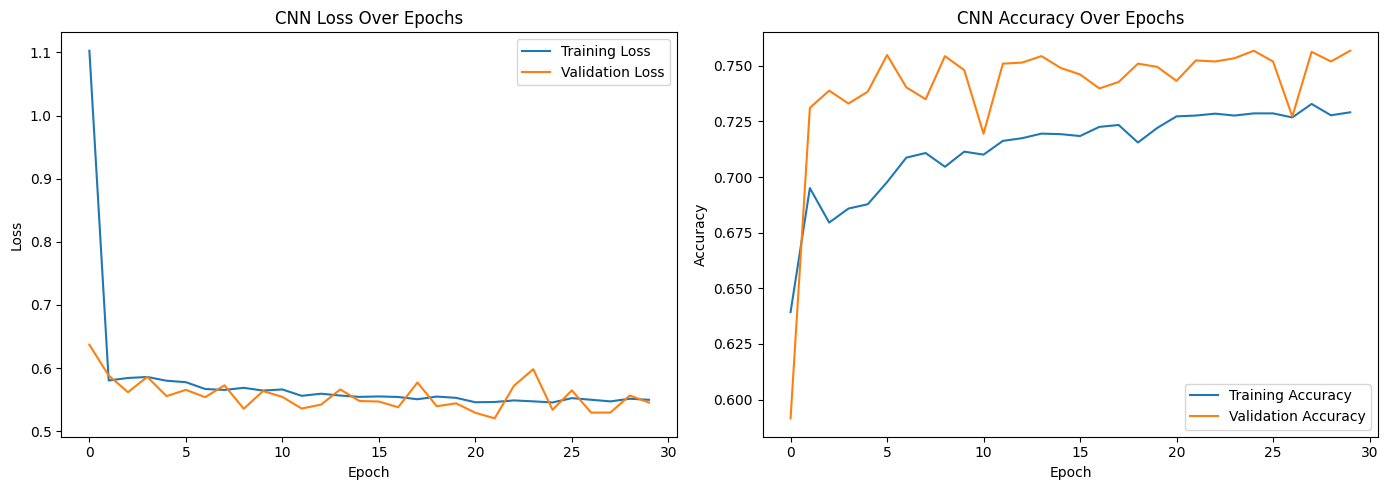

In [ ]:
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Similar study report

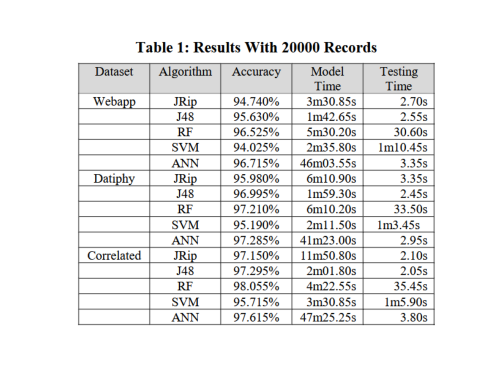

In [ ]:
img = mpimg.imread('/similar_study.PNG')
plt.imshow(img)
plt.axis('off')
plt.show()